# **Step 0 — Setup & Imports**


In [ ]:
# If running in Colab, install libs
!pip -q install shap lime fairlearn==0.10.0 imbalanced-learn

import os, json, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

import shap
from lime.lime_tabular import LimeTabularExplainer

from fairlearn.metrics import (
    MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference,
    true_positive_rate, false_positive_rate
)
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
from fairlearn.postprocessing import ThresholdOptimizer

plt.rcParams["figure.figsize"] = (8,5)
SEED = 42
np.random.seed(SEED)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 8.0 MB/s eta 0:00:00


# **Step 1 — Dataset & Model Selection**

In [ ]:
# === STEP 1 (REPLACEMENT): DATASET & MODEL SELECTION ===
import os, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler

SEED = 42
np.random.seed(SEED)

# 1.1 Load
CSV_PATHS = ["/content/voltas_featured.csv", "/mnt/data/voltas_featured.csv"]
csv_path = next((p for p in CSV_PATHS if os.path.exists(p)), CSV_PATHS[0])
if not os.path.exists(csv_path):
    from google.colab import files
    uploaded = files.upload()
    csv_path = list(uploaded.keys())[0]

df = pd.read_csv(csv_path)
print("Shape:", df.shape)
print("Columns:", list(df.columns))

# 1.2 Target (force map to 0/1)
y_col = "availability"  # adjust if different
if y_col not in df.columns:
    raise ValueError(f"Column '{y_col}' not found.")

label_map = {
    "in stock": 0, "instock": 0, "available": 0, "0": 0, "false": 0, "no": 0,
    "out of stock": 1, "outofstock": 1, "unavailable": 1, "1": 1, "true": 1, "yes": 1
}
df[y_col] = (
    df[y_col].astype(str).str.strip().str.lower().map(label_map)
)
if df[y_col].isna().any():
    bad_vals = (df.loc[df[y_col].isna(), y_col]).index.tolist()[:10]
    raise ValueError(f"Unmapped values in '{y_col}' at rows: {bad_vals}. Fix and rerun.")

df[y_col] = df[y_col].astype(int)
y = df[y_col].values
X = df.drop(columns=[y_col])

# 1.3 Sensitive attribute (for fairness)
# Prefer typical columns; else pick first categorical; else synthesize.
candidate_sens = ["gender","Gender","sex","Sex","race","Race","region","Region","city","City"]
sens_col = next((c for c in candidate_sens if c in X.columns), None)
if sens_col is None:
    cat_cols_probe = X.select_dtypes(include=["object","category"]).columns.tolist()
    if cat_cols_probe:
        sens_col = cat_cols_probe[0]
    else:
        # synthesize from first numeric column median
        num_cols_probe = X.select_dtypes(include=[np.number]).columns.tolist()
        if not num_cols_probe:
            X["sensitive_group"] = np.where(np.random.rand(len(X)) < 0.5, "GroupA", "GroupB")
        else:
            base = num_cols_probe[0]
            thr = X[base].median()
            X["sensitive_group"] = np.where(X[base] >= thr, f"High_{base}", f"Low_{base}")
        sens_col = "sensitive_group"

print("Sensitive attribute for audit:", sens_col)

# 1.4 Split (stratified by y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=SEED, stratify=y
)
sensitive_train = X_train[sens_col].astype(str)
sensitive_test  = X_test[sens_col].astype(str)

# Remove sensitive column from model features (keep it for audit only)
X_train = X_train.drop(columns=[sens_col])
X_test  = X_test.drop(columns=[sens_col])

# 1.5 Preprocess
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object","category","bool"]).columns.tolist()

from sklearn.utils.validation import check_is_fitted
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("sc", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("oh",  OneHotEncoder(handle_unknown="ignore", sparse_output=False))]), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

X_train_enc = preprocess.fit_transform(X_train)
X_test_enc  = preprocess.transform(X_test)

# 1.6 Oversample to balance classes
ros = RandomOverSampler(random_state=SEED)
X_train_bal, y_train_bal = ros.fit_resample(X_train_enc, y_train)

# 1.7 Feature names helper
def get_feature_names(ct):
    names=[]
    for name, trans, cols in ct.transformers_:
        if name == "num":
            names.extend(cols)
        elif name == "cat":
            try:
                oh = trans.named_steps["oh"]
                names.extend(list(oh.get_feature_names_out(cols)))
            except:
                names.extend(cols)
    return names

feature_names = get_feature_names(preprocess)

print(f"Encoded train shape (before/after ROS): {X_train_enc.shape} -> {X_train_bal.shape}")
print(f"#Features: {len(feature_names)}; first 10: {feature_names[:10]}")


Saving voltas_featured.csv to voltas_featured.csv
Shape: (500, 32)
Columns: ['product_id', 'product_category', 'sub_type', 'model_name', 'capacity_tons', 'capacity_liters', 'capacity_kg', 'capacity_place_settings', 'technology', 'feature_1', 'energy_rating_stars', 'color', 'price_inr', 'manufacturing_date', 'warranty_years', 'customer_rating', 'city', 'platform', 'discount_offered', 'availability', 'warranty_duration_months', 'review_sentiment', 'return_status', 'complaint_text', 'resolved_status', 'review_date', 'reviewer_location', 'product_name', 'username', 'capacity_unified', 'price_density_score', 'warranty_quality_interaction']
Sensitive attribute for audit: city
Encoded train shape (before/after ROS): (375, 2162) -> (398, 2162)
#Features: 2162; first 10: ['capacity_tons', 'capacity_liters', 'capacity_kg', 'capacity_place_settings', 'energy_rating_stars', 'price_inr', 'warranty_years', 'customer_rating', 'discount_offered', 'warranty_duration_months']


# **Step 2 — Train Classifiers (LogReg, RandomForest)**

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

# Train
lr = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=SEED)
lr.fit(X_train_bal, y_train_bal)

rf = RandomForestClassifier(
    n_estimators=300, max_depth=None, random_state=SEED, class_weight="balanced_subsample"
)
rf.fit(X_train_bal, y_train_bal)

def safe_auc(y_true, y_prob):
    try:
        return roc_auc_score(y_true, y_prob)
    except Exception:
        return np.nan

def evaluate(model, Xtr, ytr, Xte, yte, name):
    pred_tr = model.predict(Xtr)
    pred_te = model.predict(Xte)
    proba_te = model.predict_proba(Xte)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\n[{name}]")
    print("Train acc:", round(accuracy_score(ytr, pred_tr), 4))
    print("Test  acc:", round(accuracy_score(yte, pred_te), 4))
    print("Test  f1 :", round(f1_score(yte, pred_te, zero_division=0), 4))
    if proba_te is not None:
        auc = safe_auc(yte, proba_te)
        print("Test  AUC:", "nan" if np.isnan(auc) else round(auc, 4))
    print(classification_report(yte, pred_te, digits=4, zero_division=0))

# Encoded sets from Step 1: X_train_bal, y_train_bal, X_test_enc, y_test
evaluate(lr, X_train_bal, y_train_bal, X_test_enc, y_test, "Logistic Regression")
evaluate(rf, X_train_bal, y_train_bal, X_test_enc, y_test, "Random Forest")



[Logistic Regression]
Train acc: 1.0
Test  acc: 0.456
Test  f1 : 0.5072
Test  AUC: 0.4789
              precision    recall  f1-score   support

           0     0.4151    0.3729    0.3929        59
           1     0.4861    0.5303    0.5072        66

    accuracy                         0.4560       125
   macro avg     0.4506    0.4516    0.4501       125
weighted avg     0.4526    0.4560    0.4533       125


[Random Forest]
Train acc: 1.0
Test  acc: 0.496
Test  f1 : 0.5772
Test  AUC: 0.4522
              precision    recall  f1-score   support

           0     0.4524    0.3220    0.3762        59
           1     0.5181    0.6515    0.5772        66

    accuracy                         0.4960       125
   macro avg     0.4852    0.4868    0.4767       125
weighted avg     0.4871    0.4960    0.4823       125



# **Step 3 — Explainability with SHAP**

 99%|===================| 247/250 [00:35<00:00]       

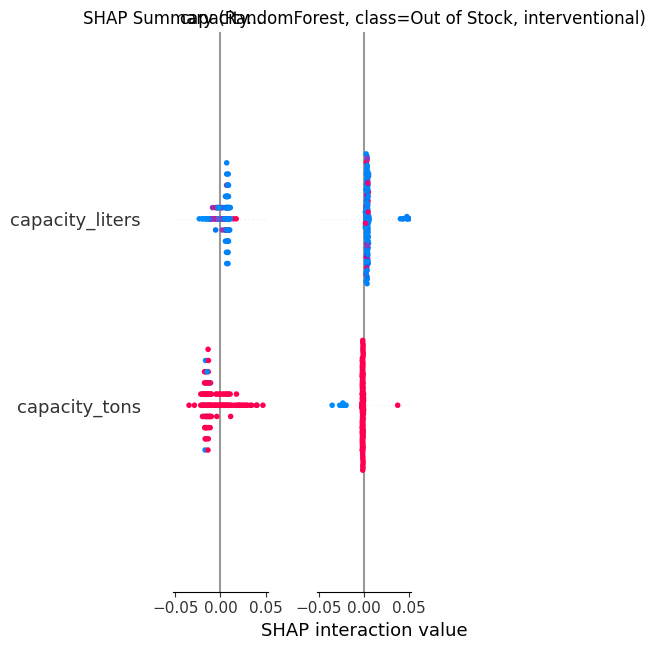

RF SHAP (interventional) failed -> falling back to classic with additivity off: only length-1 arrays can be converted to Python scalars


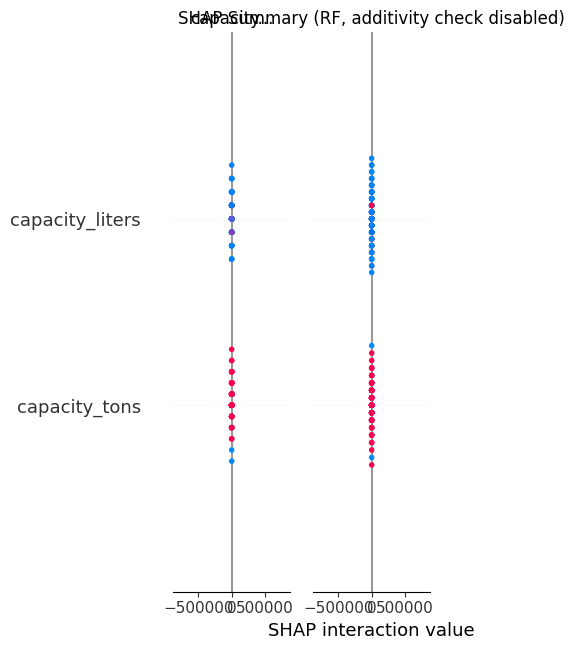

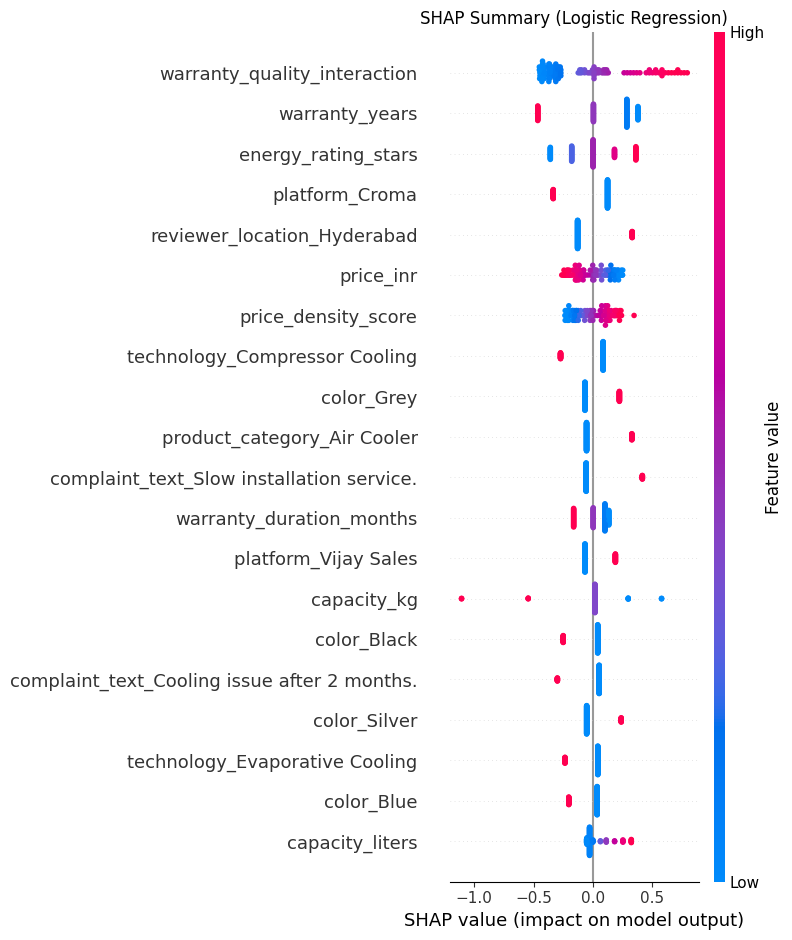

In [ ]:
import numpy as np, matplotlib.pyplot as plt, shap
from pathlib import Path
Path(".").mkdir(exist_ok=True)

# Use a small background sample from the *training space the RF was trained on* (X_train_bal)
bg_size = min(200, X_train_bal.shape[0])
background = shap.sample(X_train_bal, bg_size, random_state=SEED)

# --- 3.1 RandomForest (TreeExplainer) with interventional perturbation + probability output ---
try:
    expl_rf = shap.TreeExplainer(
        rf,
        data=background,
        feature_perturbation="interventional",
        model_output="probability"
    )
    # New API returns Explanation if called directly; fallback to classic with additivity off
    try:
        shap_values_rf = expl_rf(X_test_enc)  # Explanation object
        sv_rf_values = shap_values_rf.values  # (n_samples, n_features)
    except Exception:
        shap_values_rf = expl_rf.shap_values(X_test_enc, check_additivity=False)
        # For binary classifiers, pick class-1 SHAPs
        sv_rf_values = shap_values_rf[1] if isinstance(shap_values_rf, list) else shap_values_rf

    # Global summary (beeswarm)
    shap.summary_plot(sv_rf_values, features=X_test_enc, feature_names=feature_names, show=False)
    plt.title("SHAP Summary (RandomForest, class=Out of Stock, interventional)")
    plt.tight_layout(); plt.savefig("shap_summary_rf.png", dpi=150); plt.show()

    # Dependence on top feature
    mean_abs = np.abs(sv_rf_values).mean(axis=0)
    top_idx = int(np.argsort(mean_abs)[-1])
    top_feat = feature_names[top_idx]
    shap.dependence_plot(top_feat, sv_rf_values, X_test_enc, feature_names=feature_names, show=False)
    plt.title(f"SHAP Dependence on '{top_feat}' (RF, interventional)")
    plt.tight_layout(); plt.savefig("shap_dependence_rf_top.png", dpi=150); plt.show()

except Exception as e:
    print("RF SHAP (interventional) failed -> falling back to classic with additivity off:", e)
    expl_rf = shap.TreeExplainer(rf)
    shap_values_rf = expl_rf.shap_values(X_test_enc, check_additivity=False)
    sv_rf_values = shap_values_rf[1] if isinstance(shap_values_rf, list) else shap_values_rf
    shap.summary_plot(sv_rf_values, features=X_test_enc, feature_names=feature_names, show=False)
    plt.title("SHAP Summary (RF, additivity check disabled)")
    plt.tight_layout(); plt.savefig("shap_summary_rf.png", dpi=150); plt.show()

# --- 3.2 (Optional) Logistic Regression with LinearExplainer ---
try:
    expl_lr = shap.LinearExplainer(lr, X_train_bal, feature_names=feature_names)
    shap_values_lr = expl_lr(X_test_enc)
    shap.summary_plot(shap_values_lr.values, X_test_enc, feature_names=feature_names, show=False)
    plt.title("SHAP Summary (Logistic Regression)")
    plt.tight_layout(); plt.savefig("shap_summary_lr.png", dpi=150); plt.show()
except Exception as e:
    print("LinearExplainer skipped:", e)

# **Step 4 — Explainability with LIME (Local)**

In [ ]:
# We'll run LIME on the encoded feature space so that explanations align with `feature_names`.
class_names = ["In Stock (0)", "Out of Stock (1)"]
lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train_bal),
    feature_names=feature_names,
    class_names=class_names,
    discretize_continuous=True,
    random_state=SEED
)

# Pick a few test instances to explain
indices_to_explain = [0, min(1, len(X_test_enc)-1), min(2, len(X_test_enc)-1)]

lime_outputs = []
for idx in indices_to_explain:
    exp = lime_explainer.explain_instance(
        data_row=X_test_enc[idx],
        predict_fn=rf.predict_proba,   # local explanation for RF
        num_features=10
    )
    html_path = f"lime_local_rf_idx{idx}.html"
    with open(html_path, "w", encoding="utf-8") as f:
        f.write(exp.as_html())
    lime_outputs.append(html_path)

print("Saved LIME explanations:", lime_outputs)


Saved LIME explanations: ['lime_local_rf_idx0.html', 'lime_local_rf_idx1.html', 'lime_local_rf_idx2.html']


# **Step 5 — Fairness Audit with Fairlearn**


=== Fairness — Group metrics (RF) ===


,accuracy,f1,tpr,fpr,selection_rate
city,,,,,
Bangalore,0.307692,0.400000,0.500000,0.857143,0.692308
Chennai,0.440000,0.533333,0.500000,0.666667,0.560000
Delhi,0.470588,0.470588,0.500000,0.555556,0.529412
Hyderabad,0.666667,0.800000,0.823529,1.000000,0.857143
Kolkata,0.533333,0.631579,0.750000,0.714286,0.733333
Mumbai,0.615385,0.615385,0.800000,0.500000,0.615385
Pune,0.428571,0.400000,0.666667,0.666667,0.666667



=== Fairness — Group metrics (LR) ===


,accuracy,f1,tpr,fpr,selection_rate
city,,,,,
Bangalore,0.230769,0.166667,0.166667,0.714286,0.461538
Chennai,0.560000,0.620690,0.562500,0.444444,0.520000
Delhi,0.294118,0.250000,0.250000,0.666667,0.470588
Hyderabad,0.523810,0.666667,0.588235,0.750000,0.619048
Kolkata,0.533333,0.533333,0.500000,0.428571,0.466667
Mumbai,0.307692,0.470588,0.800000,1.000000,0.923077
Pune,0.571429,0.526316,0.833333,0.533333,0.619048


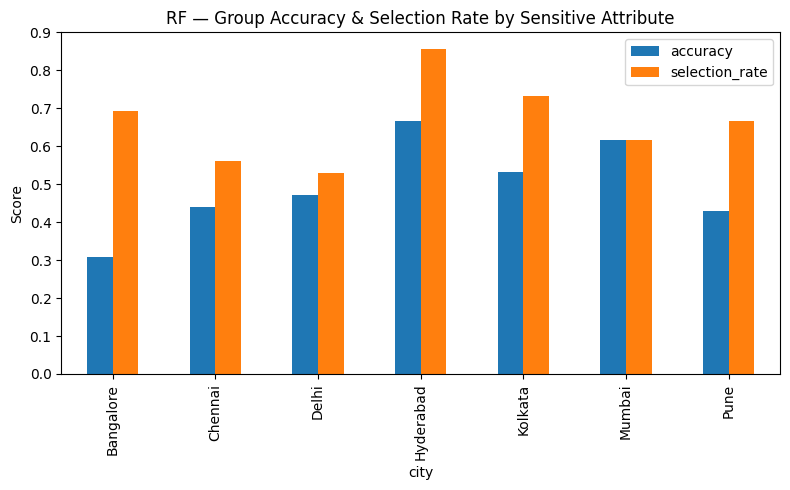


=== Fairness Summary (lower absolute = better) ===


,model,demographic_parity_diff,equalized_odds_diff
0,RandomForest,0.327731,0.500000
1,LogisticRegression,0.461538,0.666667


Saved: fairness_audit_summary.csv


In [ ]:
# Predictions
y_pred_rf = rf.predict(X_test_enc)
y_prob_rf = rf.predict_proba(X_test_enc)[:,1]
y_pred_lr = lr.predict(X_test_enc)

# MetricFrame across sensitive groups
def group_report(y_true, y_pred, sensitive):
    mf = MetricFrame(
        metrics={
            "accuracy": accuracy_score,
            "f1": f1_score,
            "tpr": true_positive_rate,
            "fpr": false_positive_rate,
            "selection_rate": selection_rate
        },
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive
    )
    return mf

mf_rf = group_report(y_test, y_pred_rf, sensitive_test)
mf_lr = group_report(y_test, y_pred_lr, sensitive_test)

print("\n=== Fairness — Group metrics (RF) ===")
display(mf_rf.by_group)
print("\n=== Fairness — Group metrics (LR) ===")
display(mf_lr.by_group)

# Group bar chart (RF accuracy & selection rate)
ax = mf_rf.by_group[["accuracy","selection_rate"]].plot(kind="bar")
plt.title("RF — Group Accuracy & Selection Rate by Sensitive Attribute")
plt.ylabel("Score")
plt.tight_layout()
plt.savefig("fairness_groups_rf.png", dpi=150)
plt.show()

# Summary fairness metrics
dpd_rf = demographic_parity_difference(y_test, y_pred_rf, sensitive_features=sensitive_test)   # closer to 0 is better
eod_rf = equalized_odds_difference(y_test, y_pred_rf, sensitive_features=sensitive_test)       # closer to 0 is better
dpd_lr = demographic_parity_difference(y_test, y_pred_lr, sensitive_features=sensitive_test)
eod_lr = equalized_odds_difference(y_test, y_pred_lr, sensitive_features=sensitive_test)

fair_summary = pd.DataFrame({
    "model":["RandomForest","LogisticRegression"],
    "demographic_parity_diff":[dpd_rf, dpd_lr],
    "equalized_odds_diff":[eod_rf, eod_lr]
})
print("\n=== Fairness Summary (lower absolute = better) ===")
display(fair_summary)

fair_summary.to_csv("fairness_audit_summary.csv", index=False)
print("Saved: fairness_audit_summary.csv")


# **Step 6 — Bias Mitigation (Pre / In / Post)**

In [ ]:
# NumPy 2.0 compatibility patch for Fairlearn (expects np.PINF/np.NINF)
import numpy as np
if not hasattr(np, "PINF"): np.PINF = np.inf
if not hasattr(np, "NINF"): np.NINF = -np.inf


In [ ]:
# === STEP 6: Bias Mitigation (Fairlearn) — with NumPy 2.0 patch ===
import numpy as np
if not hasattr(np, "PINF"): np.PINF = np.inf
if not hasattr(np, "NINF"): np.NINF = -np.inf

from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import (
    MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference,
    true_positive_rate, false_positive_rate
)
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

def group_report(y_true, y_pred, sensitive):
    return MetricFrame(
        metrics={
            "accuracy": accuracy_score,
            "f1": f1_score,
            "tpr": true_positive_rate,
            "fpr": false_positive_rate,
            "selection_rate": selection_rate,
        },
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive
    )

# Use ORIGINAL encoded training set (no ROS) to align lengths with sensitive_train
X_fair = X_train_enc
y_fair = y_train
s_fair = sensitive_train.values.astype(str)

# ---- In-processing: ExponentiatedGradient (Demographic Parity) ----
constraint = DemographicParity()  # or EqualizedOdds()
mitigator = ExponentiatedGradient(
    estimator=LogisticRegression(max_iter=2000),
    constraints=constraint,
    eps=0.01
)
mitigator.fit(X_fair, y_fair, sensitive_features=s_fair)
y_pred_mitigated = mitigator.predict(X_test_enc)

mf_mitigated = group_report(y_test, y_pred_mitigated, sensitive_test)
dpd_mit = demographic_parity_difference(y_test, y_pred_mitigated, sensitive_features=sensitive_test)
eod_mit = equalized_odds_difference(y_test, y_pred_mitigated, sensitive_features=sensitive_test)
print("\n=== In-processing Mitigation (ExponentiatedGradient) ===")
display(mf_mitigated.by_group)
print(f"DP diff: {dpd_mit:.4f} | EO diff: {eod_mit:.4f}")

# ---- Post-processing: ThresholdOptimizer on RF probs ----
postproc = ThresholdOptimizer(
    estimator=rf, constraints="demographic_parity",
    predict_method="predict_proba", prefit=True
)
postproc.fit(X_fair, y_fair, sensitive_features=s_fair)
y_pred_post = postproc.predict(X_test_enc, sensitive_features=sensitive_test.values.astype(str))

mf_post = group_report(y_test, y_pred_post, sensitive_test)
dpd_post = demographic_parity_difference(y_test, y_pred_post, sensitive_features=sensitive_test)
eod_post = equalized_odds_difference(y_test, y_pred_post, sensitive_features=sensitive_test)
print("\n=== Post-processing Mitigation (ThresholdOptimizer) ===")
display(mf_post.by_group)
print(f"DP diff: {dpd_post:.4f} | EO diff: {eod_post:.4f}")

# ---- Compare ----
fair_compare = pd.DataFrame({
    "setting": ["RF (raw)", "LR (raw)", "LR + In-Proc", "RF + Post-Proc"],
    "DP_diff": [demographic_parity_difference(y_test, rf.predict(X_test_enc), sensitive_features=sensitive_test),
                demographic_parity_difference(y_test, lr.predict(X_test_enc), sensitive_features=sensitive_test),
                dpd_mit, dpd_post],
    "EO_diff": [equalized_odds_difference(y_test, rf.predict(X_test_enc), sensitive_features=sensitive_test),
                equalized_odds_difference(y_test, lr.predict(X_test_enc), sensitive_features=sensitive_test),
                eod_mit, eod_post]
})
display(fair_compare)
fair_compare.to_csv("fairness_compare_all.csv", index=False)
print("Saved: fairness_compare_all.csv")


=== In-processing Mitigation (ExponentiatedGradient) ===


,accuracy,f1,tpr,fpr,selection_rate
city,,,,,
Bangalore,0.076923,0.000000,0.000000,0.857143,0.461538
Chennai,0.600000,0.666667,0.625000,0.444444,0.560000
Delhi,0.352941,0.266667,0.250000,0.555556,0.411765
Hyderabad,0.619048,0.750000,0.705882,0.750000,0.714286
Kolkata,0.533333,0.588235,0.625000,0.571429,0.600000
Mumbai,0.384615,0.500000,0.800000,0.875000,0.846154
Pune,0.619048,0.555556,0.833333,0.466667,0.571429


DP diff: 0.4344 | EO diff: 0.8333

=== Post-processing Mitigation (ThresholdOptimizer) ===


,accuracy,f1,tpr,fpr,selection_rate
city,,,,,
Bangalore,0.307692,0.470588,0.666667,1.000000,0.846154
Chennai,0.520000,0.647059,0.687500,0.777778,0.720000
Delhi,0.529412,0.000000,0.000000,0.000000,0.000000
Hyderabad,0.666667,0.800000,0.823529,1.000000,0.857143
Kolkata,0.466667,0.555556,0.625000,0.714286,0.666667
Mumbai,0.615385,0.615385,0.800000,0.500000,0.615385
Pune,0.380952,0.434783,0.833333,0.800000,0.809524


DP diff: 0.8571 | EO diff: 1.0000


,setting,DP_diff,EO_diff
0,RF (raw),0.327731,0.500000
1,LR (raw),0.461538,0.666667
2,LR + In-Proc,0.434389,0.833333
3,RF + Post-Proc,0.857143,1.000000


Saved: fairness_compare_all.csv


In [ ]:
# --- in your notebook, AFTER training ---
import os, json, joblib
from sklearn.pipeline import Pipeline

ARTIFACTS_DIR = "deploy_artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# choose the model you want to serve
best_model = rf   # or lr

# columns the model expects at inference (your X_train AFTER dropping target/sensitive)
expected_input_cols = X_train.columns.tolist()

# build an inference pipeline using the fitted preprocess and the fitted model
inference_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),  # already fitted on training data
    ("model", best_model)        # already fitted on encoded training data
])

joblib.dump(inference_pipeline, f"{ARTIFACTS_DIR}/inference_pipeline.joblib")
json.dump({"expected_input_cols": expected_input_cols},
          open(f"{ARTIFACTS_DIR}/expected_columns.json","w"))

print("Saved:", os.listdir(ARTIFACTS_DIR))


Saved: ['inference_pipeline.joblib', 'expected_columns.json']


In [ ]:
# after training (you already saved inference_pipeline + expected_columns)
import pandas as pd, os, joblib, json

ART = "app/artifacts"
os.makedirs(ART, exist_ok=True)

# If you still have your original X_train before dropping 'availability'
# and before removing the sensitive column for training:
ref_cols = X_train.columns
ref = X_train.sample(n=min(200, len(X_train)), random_state=42).copy()
ref.to_csv(f"{ART}/reference_sample.csv", index=False)

print(os.listdir(ART))


['reference_sample.csv']
